In [1]:
from airflow import DAG
from airflow.utils.dates import days_ago
from airflow.operators.python import PythonOperator
import datetime
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io.json as pjson

In [2]:
klin_conn = {
    'host': 'localhost', #db in prod, '51.158.67.16'
    'user': 'root',
    'password': 'password',
    'database': 'klines_history',
    'port': "3306",
    'auth_plugin': 'mysql_native_password'
}


In [3]:
def sql_to_df(connector, table):    
    connexion = mysql.connector.connect(**connector)
    curseur = connexion.cursor()
    requete_sql = f"SELECT * FROM {table} WHERE TimeStep != 'WEEKLY'"
    curseur.execute(requete_sql)
    dataframe = pd.DataFrame(curseur.fetchall(), columns=curseur.column_names)
    curseur.close()
    connexion.close()
    return dataframe

def get_result():
    df_klines = sql_to_df(klin_conn, 'klines')
    df_predictions = sql_to_df(klin_conn, 'predictions')

    df_work = df_predictions.merge(right = df_klines, on = ['Symbol', 'TimeStep', 'OpenTime'], how = 'left')
    df_work['precision'] = abs((df_work['ClosePrice_y'] - df_work['ClosePrice_x']) / df_work['ClosePrice_y']) * 100

    result = round(df_work['precision'].mean(),2)
    print('erreur moyenne calculee : ' + str(result) + '%')

,Symbol,TimeStep,OpenTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
7,ADAUSDT,MINUTELY,2023-09-19 19:23:00,0.2558,0.2558,0.2558,0.2558,719.80000
14855,BNBUSDT,MINUTELY,2023-09-19 19:23:00,217.3000,217.4000,217.2000,217.4000,325.24000
29703,BTCUSDT,MINUTELY,2023-09-19 19:23:00,27163.7300,27170.4300,27159.9300,27170.4300,11.76027
44551,ETHUSDT,MINUTELY,2023-09-19 19:23:00,1646.1500,1646.2400,1645.8000,1646.2400,43.36160
59399,XRPUSDT,MINUTELY,2023-09-19 19:23:00,0.5114,0.5119,0.5114,0.5118,61939.00000


In [27]:
get_result()

erreur moyenne calculee : 11.84%


In [4]:
df_klines = sql_to_df(klin_conn, 'klines')
df_predictions = sql_to_df(klin_conn, 'predictions')

df_work = df_predictions.merge(right = df_klines, on = ['Symbol', 'TimeStep', 'OpenTime'], how = 'left')
df_work['precision'] = abs((df_work['ClosePrice_y'] - df_work['ClosePrice_x']) / df_work['ClosePrice_y']) * 100

In [5]:
df_work['TimeStep'].value_counts()

TimeStep
MINUTELY    92560
HOURLY       1560
DAILY          85
Name: count, dtype: int64

In [6]:
df_predictions[df_predictions['TimeStep'] == 'DAILY']

,Symbol,TimeStep,InTime,OpenTime,PctChange,ClosePrice
18824,ADAUSDT,DAILY,2023-09-19 19:23:31,2023-09-20 02:00:00,0.299959,0.325380
18825,ADAUSDT,DAILY,2023-09-19 19:23:31,2023-09-21 02:00:00,0.287800,0.318215
18826,ADAUSDT,DAILY,2023-09-19 19:23:31,2023-09-22 02:00:00,0.313812,0.330555
18827,ADAUSDT,DAILY,2023-09-19 19:23:31,2023-09-23 02:00:00,0.308036,0.334726
18828,ADAUSDT,DAILY,2023-09-20 08:51:30,2023-09-24 02:00:00,0.080247,0.272762
...,...,...,...,...,...,...
94200,XRPUSDT,DAILY,2023-09-28 13:34:04,2023-10-02 02:00:00,0.081993,0.543161
94201,XRPUSDT,DAILY,2023-09-29 08:56:16,2023-10-03 02:00:00,-0.038395,0.487822
94202,XRPUSDT,DAILY,2023-10-01 13:24:51,2023-10-04 02:00:00,0.109272,0.571164
94203,XRPUSDT,DAILY,2023-10-01 13:24:51,2023-10-05 02:00:00,0.117475,0.582093


In [7]:
df_work_graph = df_work.dropna()
df_work_graph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94145 entries, 0 to 94200
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Symbol        94145 non-null  object        
 1   TimeStep      94145 non-null  object        
 2   InTime        94145 non-null  datetime64[ns]
 3   OpenTime      94145 non-null  datetime64[ns]
 4   PctChange     94145 non-null  float64       
 5   ClosePrice_x  94145 non-null  float64       
 6   OpenPrice     94145 non-null  float64       
 7   HighPrice     94145 non-null  float64       
 8   LowPrice      94145 non-null  float64       
 9   ClosePrice_y  94145 non-null  float64       
 10  Volume        94145 non-null  float64       
 11  precision     94145 non-null  float64       
dtypes: datetime64[ns](2), float64(8), object(2)
memory usage: 9.3+ MB


In [8]:
df_work_graph['TimeStep'].unique()

array(['MINUTELY', 'HOURLY', 'DAILY'], dtype=object)

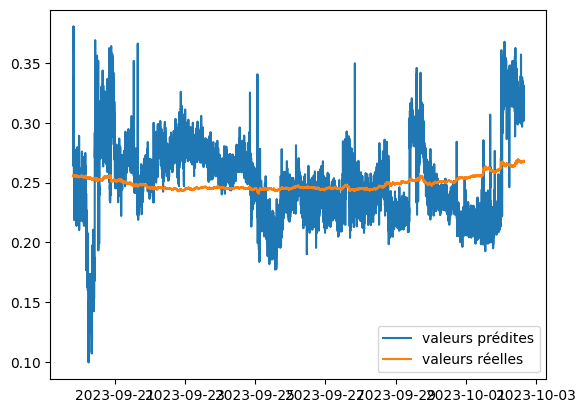

In [9]:
df_work_graph[(df_work_graph['Symbol'] == 'ADAUSDT') & (df_work_graph['TimeStep'] == 'MINUTELY')]['OpenTime']
plt.plot(df_work_graph[(df_work_graph['Symbol'] == 'ADAUSDT') & (df_work_graph['TimeStep'] == 'MINUTELY')]['OpenTime'], df_work_graph[(df_work_graph['Symbol'] == 'ADAUSDT') & (df_work_graph['TimeStep'] == 'MINUTELY')]['ClosePrice_x'], label = "valeurs prédites")
plt.plot(df_work_graph[(df_work_graph['Symbol'] == 'ADAUSDT') & (df_work_graph['TimeStep'] == 'MINUTELY')]['OpenTime'], df_work_graph[(df_work_graph['Symbol'] == 'ADAUSDT') & (df_work_graph['TimeStep'] == 'MINUTELY')]['ClosePrice_y'], label = "valeurs réelles")
plt.legend()

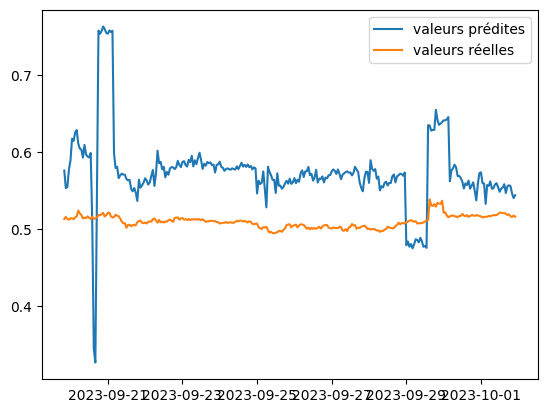

In [35]:
plt.plot(df_work_graph[(df_work_graph['Symbol'] == 'XRPUSDT') & (df_work_graph['TimeStep'] == 'HOURLY')]['OpenTime'], df_work_graph[(df_work_graph['Symbol'] == 'XRPUSDT') & (df_work_graph['TimeStep'] == 'HOURLY')]['ClosePrice_x'], label = "valeurs prédites")
plt.plot(df_work_graph[(df_work_graph['Symbol'] == 'XRPUSDT') & (df_work_graph['TimeStep'] == 'HOURLY')]['OpenTime'], df_work_graph[(df_work_graph['Symbol'] == 'XRPUSDT') & (df_work_graph['TimeStep'] == 'HOURLY')]['ClosePrice_y'], label = "valeurs réelles")
plt.legend()

In [10]:
result = df_work[['Symbol', 'TimeStep', 'precision']].groupby(by=['Symbol', 'TimeStep']).mean()

In [13]:
result = result.reset_index()

In [11]:
df_precision = sql_to_df(klin_conn, "hist_detailed_precision")

In [12]:
df_precision

,id,date,symbol,timestep,precision_rate
0,1,2023-09-29 07:11:48,ADAUSDT,DAILY,18.40
1,2,2023-09-29 07:11:48,ADAUSDT,HOURLY,38.07
2,3,2023-09-29 07:11:48,ADAUSDT,MINUTELY,9.33
3,5,2023-09-29 07:11:48,BNBUSDT,DAILY,16.06
4,6,2023-09-29 07:11:48,BNBUSDT,HOURLY,32.35
...,...,...,...,...,...
28810,30251,2023-10-02 13:52:02,ETHUSDT,HOURLY,7.58
28811,30252,2023-10-02 13:52:02,ETHUSDT,MINUTELY,14.73
28812,30253,2023-10-02 13:52:02,XRPUSDT,DAILY,14.72
28813,30254,2023-10-02 13:52:02,XRPUSDT,HOURLY,13.68


In [13]:
df_precision[(df_precision['symbol'] == 'ETHUSDT') & (df_precision['timestep'] == 'ETHUSDT')]['precision_rate']

Series([], Name: precision_rate, dtype: float64)

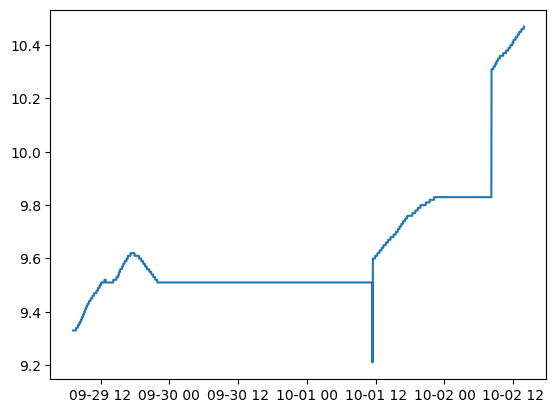

In [14]:
plt.plot(df_precision[(df_precision['symbol'] == 'ADAUSDT') & (df_precision['timestep'] == 'MINUTELY')]['date'], df_precision[(df_precision['symbol'] == 'ADAUSDT') & (df_precision['timestep'] == 'MINUTELY')]['precision_rate'])

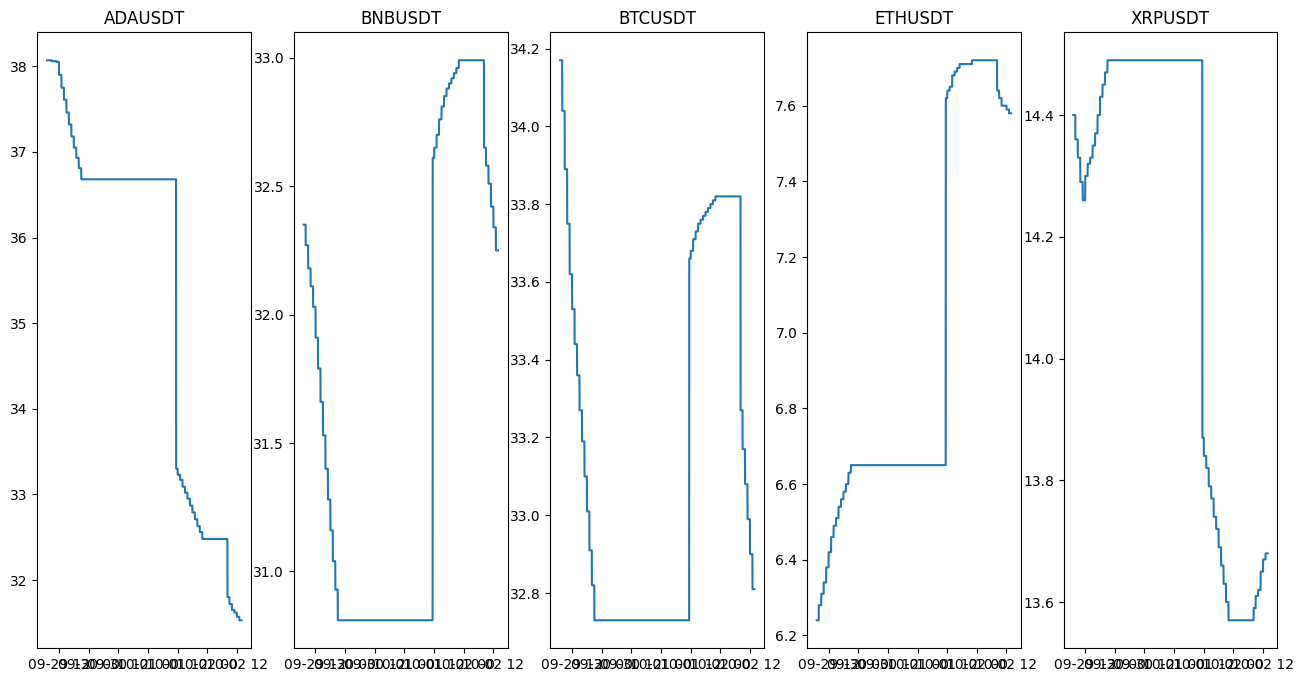

In [16]:
plt.figure(figsize=(16,8))

for index, symbol in enumerate(df_precision['symbol'].unique()):
    plt.subplot(1,len(df_precision['symbol'].unique()), index +1)
    plt.plot(df_precision[(df_precision['symbol'] == symbol) & (df_precision['timestep'] == 'HOURLY')]['date'], df_precision[(df_precision['symbol'] == symbol) & (df_precision['timestep'] == 'HOURLY')]['precision_rate'])
    plt.title(symbol)
    
    

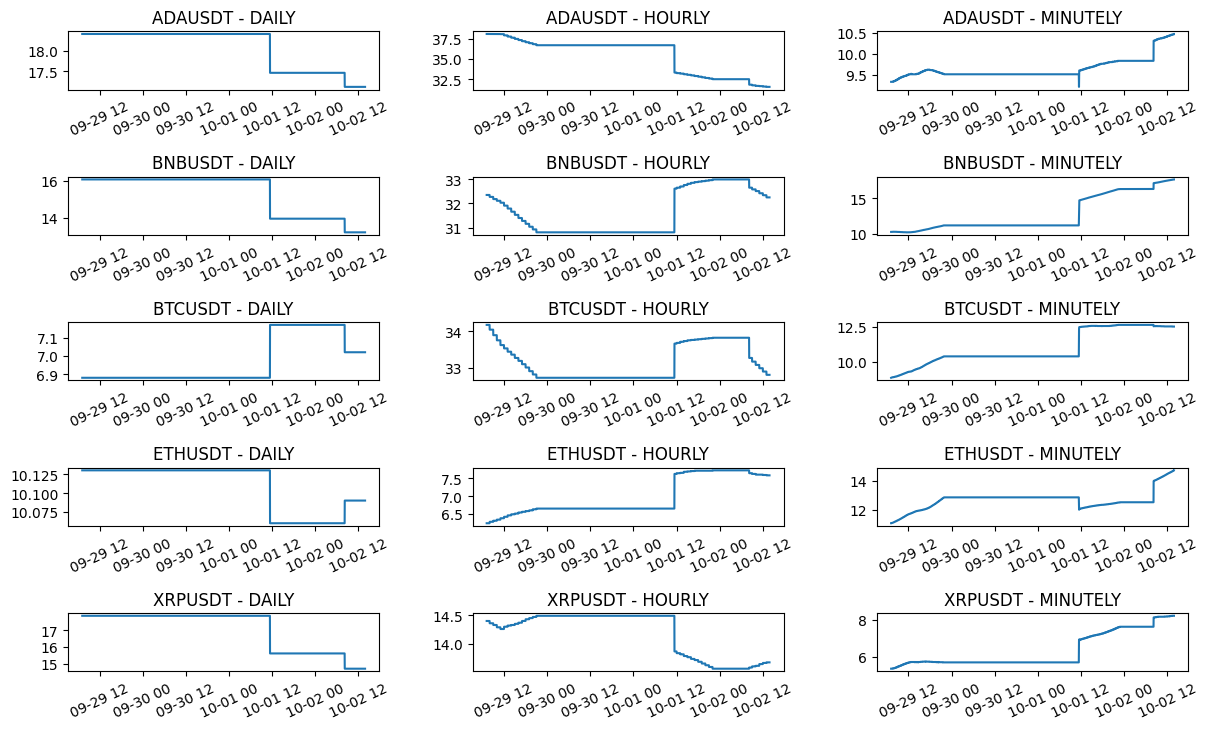

In [17]:
plt.figure(figsize=(14,8))
i = 1

for symbol in df_precision['symbol'].unique():
    for timestep in df_precision['timestep'].unique():
        plt.subplot(len(df_precision['symbol'].unique()),len(df_precision['timestep'].unique()), i )
        plt.plot(df_precision[(df_precision['symbol'] == symbol) & (df_precision['timestep'] == timestep)]['date'], df_precision[(df_precision['symbol'] == symbol) & (df_precision['timestep'] == timestep)]['precision_rate'])
        plt.title(symbol + " - " + timestep)
        plt.xticks(rotation=25)
        i += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=1.5)



In [20]:
    fig = go.Figure(
        data = [
            go.Line(x=df_precision[(df_precision['symbol'] == symbol) & (df_precision['timestep'] == timestep)]['date'],y= df_precision[(df_precision['symbol'] == symbol) & (df_precision['timestep'] == timestep)]['precision_rate'], line_color='orange', mode='lines+markers+text', name='')
        ],
        layout = go.Layout(
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            margin={ 't': 0, 'r': 0, 'b': 0, 'l': 0 },
            showlegend=False,
            yaxis_title=None,
            xaxis_title=None
        )
    )
    fig.update_yaxes(gridcolor='rgba(0,0,0,.1)')
    fig.update_xaxes(showgrid=False)

d:\dev\python\v3.11.4\Lib\site-packages\plotly\graph_objs\_deprecations.py:378 DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

In [27]:
def connect():
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='password',
        database='klines_history'
    )
    return conn

In [35]:
    dbconn = connect()
    cursor = dbconn.cursor(dictionary=True)
    query = """
    SELECT * from hist_detailed_precision
    """
    cursor.execute(query)
    datas = cursor.fetchall()
    cursor.close()
    dbconn.close()

    dates = [x['date'] for x in datas]
    data_precision = [x['precision_rate'] for x in datas]

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [54]:


# Extraction des symboles uniques et des délais uniques
symbols = set(entry['symbol'] for entry in datas)
timesteps = set(entry['timestep'] for entry in datas)

# Créez une sous-figure avec Plotly
fig = make_subplots(rows=len(symbols), cols=len(timesteps), subplot_titles=[])


j = 1

# Boucle sur les symboles uniques
for symbol in symbols:
    i = 1
    # Boucle sur les délais uniques
    for timestep in timesteps:
    
        # Filtrer les données pour le symbole et le délai actuels
        subset = [entry for entry in datas if entry['symbol'] == symbol and entry['timestep'] == timestep]

        # Extraire les dates et les taux de précision pour le sous-graphique actuel
        dates = [entry['date'] for entry in subset]
        precision_rates = [entry['precision_rate'] for entry in subset]

        # Créer une trace de ligne avec Plotly pour le sous-graphique actuel
        trace = go.Scatter(x=dates, y=precision_rates, mode='lines+markers', name=symbol + " - " + timestep)
        
        # # Ajouter la trace au sous-graphique correspondant
        fig.add_trace(trace, row=j, col=i)

        # Mettre à jour les titres des sous-graphiques
        fig.update_xaxes(title_text='Date', row=i, col=1)
        fig.update_yaxes(title_text='Taux de précision', row=i, col=1)

        i += 1
    j += 1

# Mettre à jour la disposition de la figure
fig.update_layout(showlegend=True)
fig.update_layout(height=600, width=800)

# Afficher la figure
fig.show()

In [46]:
len(symbols)

5

In [47]:
len(timesteps)

4

In [48]:
i

5